In [1]:
import matplotlib.pyplot as plt
import pandas as pd, datetime as dt
import scipy.stats as st
import numpy as np
from states import states

In [2]:
#read all datasets
div_df = pd.read_csv('datasets/diversity_index_counties.csv')
el_df = pd.read_csv('datasets/ElectionResults2020.csv')
pop_df = pd.read_csv('datasets/uscensuspop2020.csv')
poverty_df = pd.read_csv('datasets/PovertyEstimates.csv')
covid_df = pd.read_csv('https://query.data.world/s/254wzyu352gsbcze7tu3pckdjuuhm3')
orig_mask_df = pd.read_csv('https://data.cdc.gov/api/views/62d6-pm5i/rows.csv?accessType=DOWNLOAD').dropna().reset_index(drop = True)
orig_mask_df

C:\Users\rhian\anaconda3_2\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,7/16/2020,1,Yes,Official,https://governor.alabama.gov/assets/2020/07/20...,"Ala. Exec. Proc. (July 15, 2020)"
1,AL,Autauga County,1,1,7/17/2020,1,Yes,Official,https://governor.alabama.gov/assets/2020/07/20...,"Ala. Exec. Proc. (July 15, 2020)"
2,AL,Autauga County,1,1,7/18/2020,1,Yes,Official,https://governor.alabama.gov/assets/2020/07/20...,"Ala. Exec. Proc. (July 15, 2020)"
3,AL,Autauga County,1,1,7/19/2020,1,Yes,Official,https://governor.alabama.gov/assets/2020/07/20...,"Ala. Exec. Proc. (July 15, 2020)"
4,AL,Autauga County,1,1,7/20/2020,1,Yes,Official,https://governor.alabama.gov/assets/2020/07/20...,"Ala. Exec. Proc. (July 15, 2020)"
...,...,...,...,...,...,...,...,...,...,...
942290,VI,St. Thomas Island,78,30,4/14/2021,1,Yes,Official,https://www.vi.gov/wp-content/uploads/2021/03/...,V.I. Supplementary Exec. Order & Proc. No. 22 ...
942291,VI,St. Thomas Island,78,30,4/15/2021,1,Yes,Official,https://www.vi.gov/wp-content/uploads/2021/03/...,V.I. Supplementary Exec. Order & Proc. No. 22 ...
942292,VI,St. Thomas Island,78,30,4/16/2021,1,Yes,Official,https://www.vi.gov/wp-content/uploads/2021/03/...,V.I. Supplementary Exec. Order & Proc. No. 22 ...
942293,VI,St. Thomas Island,78,30,4/17/2021,1,Yes,Official,https://www.vi.gov/wp-content/uploads/2021/03/...,V.I. Supplementary Exec. Order & Proc. No. 22 ...


In [3]:
#narrow mask dataset
mask_df = orig_mask_df[['State_Tribe_Territory', 'County_Name', 'date', 'Face_Masks_Required_in_Public']]
#convert state abbv to state name to more easily combine datasets
mask_df['State'] = [states[x] if x in states.keys() else '' for x in mask_df['State_Tribe_Territory']]
#make county_name match covid data format
mask_df['County'] = [x.replace(' County', '') for x in mask_df['County_Name']]
#convert dates from string to datetime
mask_df['Date'] = pd.to_datetime(mask_df['date'])
mask_df = mask_df.sort_values(by='Date')
#narrow cols
mask_df = mask_df[['State', 'County', 'Date', 'Face_Masks_Required_in_Public']]
#remove blanks
mask_df = mask_df.dropna()
#reset index
mask_df = mask_df.reset_index(drop=True)
#display
mask_df

C:\Users\rhian\AppData\Local\Temp/ipykernel_33896/2639431857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['State'] = [states[x] if x in states.keys() else '' for x in mask_df['State_Tribe_Territory']]
C:\Users\rhian\AppData\Local\Temp/ipykernel_33896/2639431857.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['County'] = [x.replace(' County', '') for x in mask_df['County_Name']]
C:\Users\rhian\AppData\Local\Temp/ipykernel_33896/2639431857.py:8: SettingWithCopyWarning: 
A value is t

,State,County,Date,Face_Masks_Required_in_Public
0,New Jersey,Warren,2020-04-10,Yes
1,New Jersey,Gloucester,2020-04-10,Yes
2,New Jersey,Monmouth,2020-04-10,Yes
3,New Jersey,Atlantic,2020-04-10,Yes
4,New Jersey,Morris,2020-04-10,Yes
...,...,...,...,...
942290,Minnesota,Wilkin,2021-08-15,No
942291,Maryland,Cecil,2021-08-15,No
942292,Kentucky,Cumberland,2021-08-15,No
942293,Wisconsin,Walworth,2021-08-15,No


In [4]:
#format diversity data
#convert state abbv to state name to more easily combine datasets
div_df['State'] = [states[x] for x in div_df['State Abbr']]
#clean
div_df['County'] = [x.replace(' County', '') for x in div_df['County']]
div_df = div_df.sort_values(by = 'County')
div_df = div_df.reset_index(drop=True)
#rename
div_df = div_df.rename(columns = {'state': 'State', 'county': 'County', 
                                     'Black or African American alone, percent, 2013':'Black-Index',
                                     'American Indian and Alaska Native alone, percent, 2013':'Native-Index',
                                     'Asian alone, percent, 2013':'Asian-Index',
                                     'Hispanic or Latino, percent, 2013':'Latin-Index',
                                     'White alone, not Hispanic or Latino, percent, 2013':'White-Index'
})
#narrow
div_df = div_df[['State', 'County', 'Diversity-Index', 
                 'Black-Index',
                 'Native-Index',
                 'Asian-Index',
                 'Latin-Index',
                 'White-Index']]
#display
div_df

,State,County,Diversity-Index,Black-Index,Native-Index,Asian-Index,Latin-Index,White-Index
0,South Carolina,Abbeville,0.445417,28.2,0.3,0.4,1.2,68.9
1,Louisiana,Acadia Parish,0.355956,18.3,0.3,0.4,2.0,78.1
2,Virginia,Accomack,0.539878,28.0,0.6,0.6,9.0,61.1
3,Idaho,Ada,0.256622,1.3,0.8,2.6,7.5,85.8
4,Missouri,Adair,0.148385,1.6,0.3,2.0,2.4,92.2
...,...,...,...,...,...,...,...,...
3138,Colorado,Yuma,0.361809,0.3,0.9,0.4,21.6,76.9
3139,Arizona,Yuma,0.512612,2.7,2.2,1.5,61.1,33.5
3140,Texas,Zapata,0.122362,0.5,0.4,0.2,93.5,5.8
3141,Texas,Zavala,0.132587,1.2,0.9,0.1,92.9,6.4


In [5]:
#format election data
el_df = el_df[el_df['won'] == True]
el_df = el_df[['state', 'county', 'party']]
el_df = el_df.rename(columns = {'state': 'State', 'county': 'County', 'party':'2020 Election Result'})
el_df['County'] = [x.replace(' County', '') for x in el_df['County']]
el_df = el_df.sort_values(by = 'County')
el_df = el_df.reset_index(drop = True)
el_df

,State,County,2020 Election Result
0,South Carolina,Abbeville,REP
1,Maine,Abbot,REP
2,Massachusetts,Abington,DEM
3,Louisiana,Acadia Parish,REP
4,Virginia,Accomack,REP
...,...,...,...
4628,Arizona,Yuma,REP
4629,Colorado,Yuma,REP
4630,Texas,Zapata,REP
4631,Texas,Zavala,DEM


In [6]:
#merge div and el
div_el_df = pd.merge(div_df, el_df, on=['County', 'State'])
div_el_df

,State,County,Diversity-Index,Black-Index,Native-Index,Asian-Index,Latin-Index,White-Index,2020 Election Result
0,South Carolina,Abbeville,0.445417,28.2,0.3,0.4,1.2,68.9,REP
1,Louisiana,Acadia Parish,0.355956,18.3,0.3,0.4,2.0,78.1,REP
2,Virginia,Accomack,0.539878,28.0,0.6,0.6,9.0,61.1,REP
3,Idaho,Ada,0.256622,1.3,0.8,2.6,7.5,85.8,REP
4,Missouri,Adair,0.148385,1.6,0.3,2.0,2.4,92.2,REP
...,...,...,...,...,...,...,...,...,...
3082,Colorado,Yuma,0.361809,0.3,0.9,0.4,21.6,76.9,REP
3083,Arizona,Yuma,0.512612,2.7,2.2,1.5,61.1,33.5,REP
3084,Texas,Zapata,0.122362,0.5,0.4,0.2,93.5,5.8,REP
3085,Texas,Zavala,0.132587,1.2,0.9,0.1,92.9,6.4,DEM


In [7]:
#format population data
pop_df = pop_df[['STNAME', 'CTYNAME', 'ESTIMATESBASE2020']]
pop_df = pop_df.rename(columns = {'STNAME': 'State', 'CTYNAME': 'County', 'ESTIMATESBASE2020':'Population'})
pop_df['County'] = [x.replace(' County', '') for x in pop_df['County']]
pop_df = pop_df.sort_values(by = 'County')
pop_df = pop_df.reset_index(drop = True)
pop_df

,State,County,Population
0,South Carolina,Abbeville,24295
1,Louisiana,Acadia Parish,57576
2,Virginia,Accomack,33413
3,Idaho,Ada,494967
4,Missouri,Adair,25314
...,...,...,...
3189,Arizona,Yuma,203881
3190,Colorado,Yuma,9988
3191,Texas,Zapata,13889
3192,Texas,Zavala,9670


In [8]:
#merge div el with pop
div_el_pop_df = pd.merge(div_el_df, pop_df, on=['County', 'State'])
div_el_pop_df

,State,County,Diversity-Index,Black-Index,Native-Index,Asian-Index,Latin-Index,White-Index,2020 Election Result,Population
0,South Carolina,Abbeville,0.445417,28.2,0.3,0.4,1.2,68.9,REP,24295
1,Louisiana,Acadia Parish,0.355956,18.3,0.3,0.4,2.0,78.1,REP,57576
2,Virginia,Accomack,0.539878,28.0,0.6,0.6,9.0,61.1,REP,33413
3,Idaho,Ada,0.256622,1.3,0.8,2.6,7.5,85.8,REP,494967
4,Missouri,Adair,0.148385,1.6,0.3,2.0,2.4,92.2,REP,25314
...,...,...,...,...,...,...,...,...,...,...
3090,Colorado,Yuma,0.361809,0.3,0.9,0.4,21.6,76.9,REP,9988
3091,Arizona,Yuma,0.512612,2.7,2.2,1.5,61.1,33.5,REP,203881
3092,Texas,Zapata,0.122362,0.5,0.4,0.2,93.5,5.8,REP,13889
3093,Texas,Zavala,0.132587,1.2,0.9,0.1,92.9,6.4,DEM,9670


In [9]:
#format county poverty data
#clean
poverty_df = poverty_df.rename(columns = {'Stabr': 'State Abbv', 'Area_name': 'County', 'PCTPOVALL_2019':'poverty rate'})
poverty_df['State'] = [states[x] for x in poverty_df['State Abbv']]
poverty_df['County'] = [x.replace(' County', '') for x in poverty_df['County']]
#narrow
poverty_df = poverty_df[['State', 'County', 'poverty rate']]
#display
poverty_df = poverty_df.sort_values(by = 'County')
poverty_df = poverty_df.reset_index(drop = True)
poverty_df

,State,County,poverty rate
0,South Carolina,Abbeville,14.8
1,Louisiana,Acadia Parish,20.3
2,Virginia,Accomack,16.4
3,Idaho,Ada,9.4
4,Kentucky,Adair,21.4
...,...,...,...
3187,Arizona,Yuma,20.4
3188,Colorado,Yuma,12.8
3189,Texas,Zapata,30.1
3190,Texas,Zavala,29.6


In [10]:
#combine div el pop with poverty data
county_df = pd.merge(poverty_df, div_el_pop_df, on=['County', 'State'])
county_df

,State,County,poverty rate,Diversity-Index,Black-Index,Native-Index,Asian-Index,Latin-Index,White-Index,2020 Election Result,Population
0,South Carolina,Abbeville,14.8,0.445417,28.2,0.3,0.4,1.2,68.9,REP,24295
1,Louisiana,Acadia Parish,20.3,0.355956,18.3,0.3,0.4,2.0,78.1,REP,57576
2,Virginia,Accomack,16.4,0.539878,28.0,0.6,0.6,9.0,61.1,REP,33413
3,Idaho,Ada,9.4,0.256622,1.3,0.8,2.6,7.5,85.8,REP,494967
4,Kentucky,Adair,21.4,0.120703,2.9,0.3,0.3,1.8,93.7,REP,18903
...,...,...,...,...,...,...,...,...,...,...,...
3100,Arizona,Yuma,20.4,0.512612,2.7,2.2,1.5,61.1,33.5,REP,203881
3101,Colorado,Yuma,12.8,0.361809,0.3,0.9,0.4,21.6,76.9,REP,9988
3102,Texas,Zapata,30.1,0.122362,0.5,0.4,0.2,93.5,5.8,REP,13889
3103,Texas,Zavala,29.6,0.132587,1.2,0.9,0.1,92.9,6.4,DEM,9670


In [11]:
#format covid dataset
#Narrow dataset to only united states
us_df = covid_df[covid_df['COUNTRY_SHORT_NAME'] == 'United States']
#convert dates to datetime
us_df['REPORT_DATE'] = pd.to_datetime(us_df['REPORT_DATE'])

C:\Users\rhian\AppData\Local\Temp/ipykernel_33896/598580589.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_df['REPORT_DATE'] = pd.to_datetime(us_df['REPORT_DATE'])


In [12]:
#For graphs needing cumulative data, I only want the most recent totals
today_df = us_df[us_df['REPORT_DATE']==max(us_df['REPORT_DATE'])]
#narrow to only cols of interest
today_df = today_df[['PROVINCE_STATE_NAME',
                     'COUNTY_NAME',
                     'PEOPLE_POSITIVE_CASES_COUNT',
                     'PEOPLE_DEATH_COUNT']]
#rename cols
today_df = today_df.rename(columns = {'PROVINCE_STATE_NAME': 'State',
                                            'COUNTY_NAME': 'County',
                                            'PEOPLE_POSITIVE_CASES_COUNT': 'Cases',
                                            'PEOPLE_DEATH_COUNT':'Deaths'})
today_df = today_df.sort_values(by = 'County')
today_df = today_df.reset_index(drop=True)
today_df

,State,County,Cases,Deaths
0,South Carolina,Abbeville,6644,69
1,Louisiana,Acadia,15878,292
2,Virginia,Accomack,6957,105
3,Idaho,Ada,134084,1019
4,Kentucky,Adair,5912,105
...,...,...,...,...
3272,Colorado,Yuma,1883,23
3273,Arizona,Yuma,62659,1167
3274,Texas,Zapata,3683,55
3275,Texas,Zavala,4049,68


In [13]:
#for graphs needing over time data, newcounts are needed instead
#narrow to only cols of interest
byday_df = us_df[['PROVINCE_STATE_NAME',
                     'COUNTY_NAME',
                     'PEOPLE_POSITIVE_NEW_CASES_COUNT',
                     'PEOPLE_DEATH_NEW_COUNT', 'REPORT_DATE']]

#rename cols
byday_df = byday_df.rename(columns = {'PROVINCE_STATE_NAME': 'State',
                                            'COUNTY_NAME': 'County',
                                            'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'Cases',
                                            'PEOPLE_DEATH_NEW_COUNT':'Deaths',
                                             'REPORT_DATE': 'Date'})
byday_df = byday_df.sort_values(by = 'Date')
byday_df = byday_df.reset_index(drop=True)

byday_df

,State,County,Cases,Deaths,Date
0,New Jersey,Salem,0,0,2020-01-21
1,Kansas,Jewell,0,0,2020-01-21
2,Oklahoma,Cherokee,0,0,2020-01-21
3,Minnesota,Yellow Medicine,0,0,2020-01-21
4,Georgia,Fannin,0,0,2020-01-21
...,...,...,...,...,...
2690412,West Virginia,Hampshire,4,0,2022-04-20
2690413,South Dakota,Oglala Lakota,1,0,2022-04-20
2690414,Colorado,El Paso,236,0,2022-04-20
2690415,Louisiana,St. James,0,0,2022-04-20


In [14]:
#merge cumulative datasets
df1 = pd.merge(today_df, county_df, how = 'outer', on = ['State', 'County'])
#calculate cases/deaths as percent of total population
df1['% Cases'] = df1['Cases']/df1['Population']*100
df1['% Deaths'] = df1['Deaths']/df1['Population']*100
#remove outliers
df1=df1[df1['% Cases'] < 50]
df1=df1[df1['% Deaths'] < 1.1]
#display
df1

,State,County,Cases,Deaths,poverty rate,Diversity-Index,Black-Index,Native-Index,Asian-Index,Latin-Index,White-Index,2020 Election Result,Population,% Cases,% Deaths
0,South Carolina,Abbeville,6644.0,69.0,14.8,0.445417,28.2,0.3,0.4,1.2,68.9,REP,24295.0,27.347191,0.284009
2,Virginia,Accomack,6957.0,105.0,16.4,0.539878,28.0,0.6,0.6,9.0,61.1,REP,33413.0,20.821237,0.314249
3,Idaho,Ada,134084.0,1019.0,9.4,0.256622,1.3,0.8,2.6,7.5,85.8,REP,494967.0,27.089483,0.205872
4,Kentucky,Adair,5912.0,105.0,21.4,0.120703,2.9,0.3,0.3,1.8,93.7,REP,18903.0,31.275459,0.555467
5,Oklahoma,Adair,7952.0,73.0,23.6,0.614293,0.5,44.0,0.5,5.8,42.2,REP,19495.0,40.789946,0.374455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3293,Colorado,Yuma,1883.0,23.0,12.8,0.361809,0.3,0.9,0.4,21.6,76.9,REP,9988.0,18.852623,0.230276
3294,Arizona,Yuma,62659.0,1167.0,20.4,0.512612,2.7,2.2,1.5,61.1,33.5,REP,203881.0,30.733124,0.572393
3295,Texas,Zapata,3683.0,55.0,30.1,0.122362,0.5,0.4,0.2,93.5,5.8,REP,13889.0,26.517388,0.395997
3296,Texas,Zavala,4049.0,68.0,29.6,0.132587,1.2,0.9,0.1,92.9,6.4,DEM,9670.0,41.871768,0.703206


In [15]:
#merge new counts datasets
byday_mask_df = pd.merge(byday_df, mask_df, on = ['State', 'County', 'Date'])
df2 = pd.merge(byday_mask_df, pop_df, on = ['State', 'County'])
#calculate cases/deaths as percent of total population
df2['% Cases'] = df2['Cases']/df2['Population']*100
df2['% Deaths'] = df2['Deaths']/df2['Population']*100
df2

,State,County,Cases,Deaths,Date,Face_Masks_Required_in_Public,Population,% Cases,% Deaths
0,New Jersey,Camden,82,6,2020-04-10,Yes,523485,0.015664,0.001146
1,New Jersey,Camden,108,0,2020-04-11,Yes,523485,0.020631,0.000000
2,New Jersey,Camden,90,3,2020-04-12,Yes,523485,0.017192,0.000573
3,New Jersey,Camden,131,3,2020-04-13,Yes,523485,0.025025,0.000573
4,New Jersey,Camden,76,6,2020-04-14,Yes,523485,0.014518,0.001146
...,...,...,...,...,...,...,...,...,...
875749,Wyoming,Albany,14,0,2021-08-11,No,37066,0.037770,0.000000
875750,Wyoming,Albany,12,0,2021-08-12,No,37066,0.032375,0.000000
875751,Wyoming,Albany,15,0,2021-08-13,No,37066,0.040468,0.000000
875752,Wyoming,Albany,0,0,2021-08-14,No,37066,0.000000,0.000000


In [16]:
#narrow to just states
state_df = df1[['State', 'Cases', 'Deaths', 'Population']].groupby('State').sum().reset_index()

#calculate cases/deaths as percent of total population
state_df['% Cases'] = state_df['Cases']/state_df['Population']*100
state_df['% Deaths'] = state_df['Deaths']/state_df['Population']*100
#sort by case rates
state_case_df = state_df.sort_values(by='% Cases')
#sort by death rates
state_death_df = state_df.sort_values(by='% Deaths')
#display
state_df.head()

,State,Cases,Deaths,Population,% Cases,% Deaths
0,Alabama,1298626.0,19524.0,5024279.0,25.847012,0.388593
1,Arizona,2019174.0,29852.0,7151502.0,28.234265,0.417423
2,Arkansas,824675.0,11597.0,9051721.0,9.110698,0.128119
3,California,9173336.0,89915.0,39538223.0,23.201184,0.227413
4,Colorado,1373266.0,12214.0,5767792.0,23.809215,0.211762


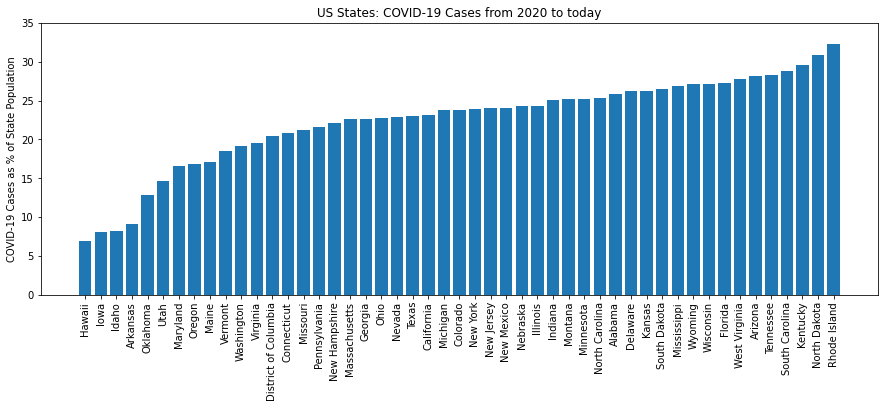

In [17]:
#State vs total case count - bar
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(state_case_df['State'],state_case_df['% Cases'])
plt.title("US States: COVID-19 Cases from 2020 to today")
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, 40, 5))
plt.ylabel("COVID-19 Cases as % of State Population")
plt.savefig('graphs/all_states_cases.png',bbox_inches="tight")
plt.show()

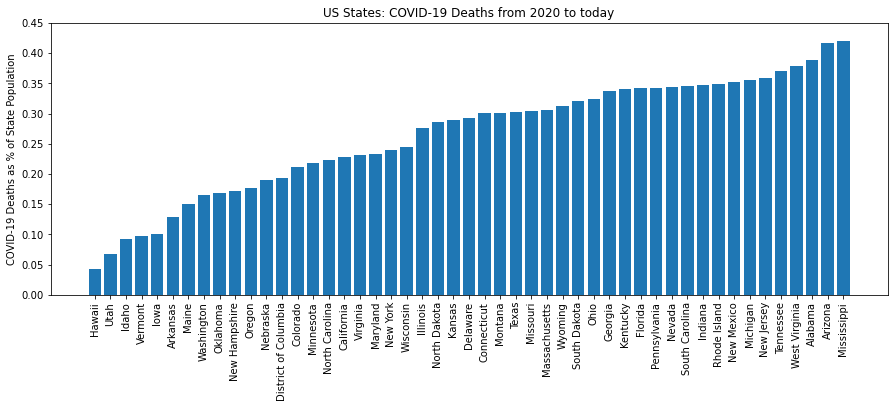

In [18]:
#State vs total death counts - bar
plt.bar(state_death_df['State'],state_death_df['% Deaths'])
plt.title("US States: COVID-19 Deaths from 2020 to today")
plt.xticks(rotation = 90)
plt.yticks(np.arange(0,0.5, 0.05))
plt.ylabel("COVID-19 Deaths as % of State Population")
plt.savefig('graphs/all_states_deaths.png',bbox_inches="tight")
plt.show()

In [19]:
#group states by 2020 election results
grouped_el_df = df1.groupby('2020 Election Result').mean()
group_df = grouped_el_df[['% Cases', '% Deaths']]
group_df = group_df.reset_index()
group_df

,2020 Election Result,% Cases,% Deaths
0,DEM,22.967501,0.289264
1,REP,24.731897,0.389379


In [20]:
#t-tests
dem_df = df1[df1['2020 Election Result']=='DEM']
rep_df = df1[df1['2020 Election Result']=='REP']
#cases
stat_c, p_c = st.ttest_ind(dem_df['% Cases'], rep_df['% Cases'])
#deaths
stat_d, p_d = st.ttest_ind(dem_df['% Deaths'], rep_df['% Deaths'])
print(p_c)
print(p_d)

1.0840074193261023e-11
2.663449931277113e-37


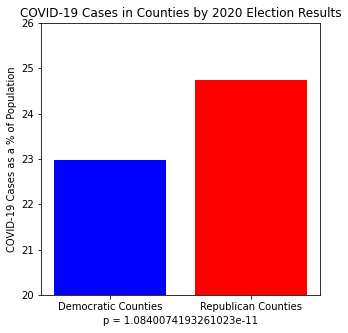

In [21]:
#Cases
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(['Democratic Counties', 'Republican Counties'],group_df['% Cases'], color = ['b', 'r'])
plt.yticks(np.arange(20,28,1))
plt.ylim(20,26)
plt.title("COVID-19 Cases in Counties by 2020 Election Results")
plt.ylabel("COVID-19 Cases as a % of Population")
plt.xlabel(f"p = {p_c}")
plt.savefig('graphs/cases_by_party.png')
plt.show()

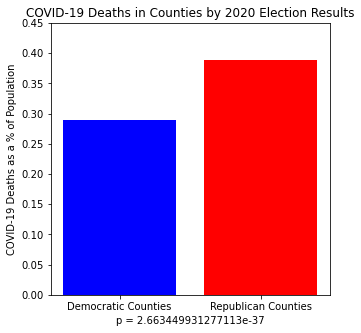

In [22]:
#Deaths
plt.rcParams["figure.figsize"] = (5,5)
plt.bar(['Democratic Counties', 'Republican Counties'],group_df['% Deaths'], color = ['b', 'r'])
plt.yticks(np.arange(0,0.5,0.05))
plt.title("COVID-19 Deaths in Counties by 2020 Election Results")
plt.ylabel("COVID-19 Deaths as a % of Population")
plt.xlabel(f"p = {p_d}")
plt.savefig('graphs/deaths_by_party.png')
plt.show()

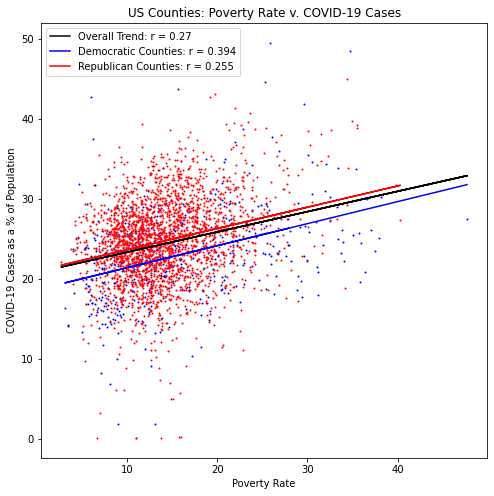

In [23]:
#income v.cases scatter plot
x = df1['poverty rate']
y = df1['% Cases']
xd = dem_df['poverty rate']
yd = dem_df['% Cases']
xr = rep_df['poverty rate']
yr = rep_df['% Cases']


plt.rcParams["figure.figsize"] = (8,8)
plt.title("US Counties: Poverty Rate v. COVID-19 Cases")
plt.ylabel("COVID-19 Cases as a % of Population")
plt.xlabel("Poverty Rate")
plt.scatter(xd,yd,s = 1, color = 'b')
plt.scatter(xr,yr,s = 1, color = 'r')

slope, intercept, r, p, std_err = st.linregress(x,y)
sloped, interceptd, rd, pd, std_errd = st.linregress(xd,yd)
sloper, interceptr, rr, pr, std_errr = st.linregress(xr,yr)

plt.plot(x,slope*x+intercept, color = 'k')
plt.plot(xd,sloped*xd+interceptd, color = 'b')
plt.plot(xr,sloper*xr+interceptr, color = 'r')

plt.legend([f"Overall Trend: r = {round(r,3)}",
            f"Democratic Counties: r = {round(rd,3)}",
            f"Republican Counties: r = {round(rr,3)}"])

plt.savefig('graphs/poverty_v_cases.png')
plt.show()


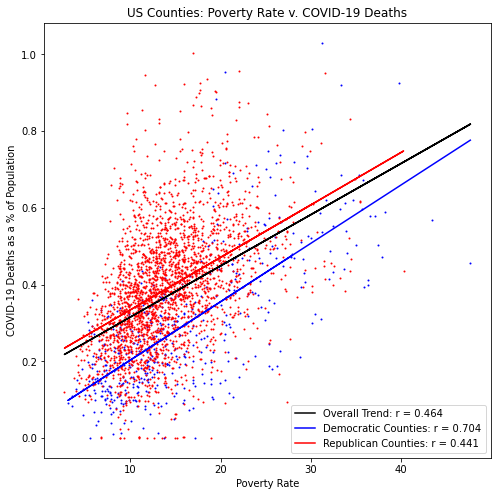

In [24]:
#income v. deaths scatter plot
x2 = df1['poverty rate']
y2 = df1['% Deaths']
xd2 = dem_df['poverty rate']
yd2 = dem_df['% Deaths']
xr2 = rep_df['poverty rate']
yr2 = rep_df['% Deaths']

slope, intercept, r, p, std_err = st.linregress(x2,y2)
sloped, interceptd, rd, pd, std_errd = st.linregress(xd2,yd2)
sloper, interceptr, rr, pr, std_errr = st.linregress(xr2,yr2)

plt.title("US Counties: Poverty Rate v. COVID-19 Deaths")
plt.ylabel("COVID-19 Deaths as a % of Population")
plt.xlabel("Poverty Rate")
plt.scatter(xd2,yd2,s = 1, color = 'b')
plt.scatter(xr2,yr2,s = 1, color = 'r')

plt.plot(x2,slope*x2+intercept, color = 'k')
plt.plot(xd2,sloped*xd2+interceptd, color = 'b')
plt.plot(xr2,sloper*xr2+interceptr, color = 'r')


plt.legend([f"Overall Trend: r = {round(r,3)}",
            f"Democratic Counties: r = {round(rd,3)}",
            f"Republican Counties: r = {round(rr,3)}"])

plt.savefig('graphs/poverty_v_deaths.png')
plt.show()

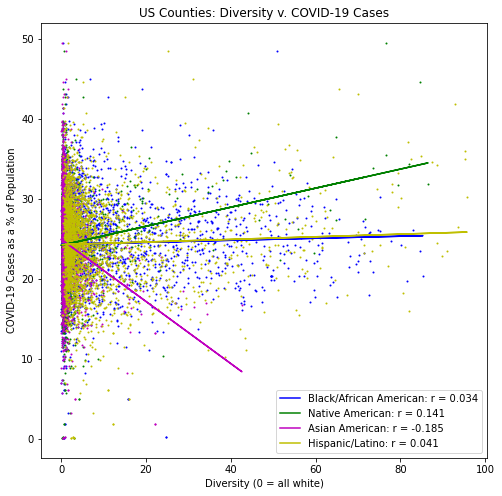

In [25]:
#diversity v. cases scatter plot
x1 = df1['Black-Index']
y1 = df1['% Cases']
plt.scatter(x1,y1,s = 1, c='b')

x2 = df1['Native-Index']
y2 = df1['% Cases']
plt.scatter(x2,y2,s = 1, c='g')

x3 = df1['Asian-Index']
y3 = df1['% Cases']
plt.scatter(x3,y3,s = 1, c='m')

x4 = df1['Latin-Index']
y4 = df1['% Cases']
plt.scatter(x4,y4,s = 1, c='y')

plt.title("US Counties: Diversity v. COVID-19 Cases")
plt.ylabel("COVID-19 Cases as a % of Population")
plt.xlabel("Diversity (0 = all white)")

slope1, intercept1, r1, p1, std_err1 = st.linregress(x1,y1)
plt.plot(x1,slope1*x1+intercept1, color = 'b')

slope2, intercept2, r2, p2, std_er2r = st.linregress(x2,y2)
plt.plot(x2,slope2*x2+intercept2, color = 'g')

slope3, intercept3, r3, p3, std_er3r = st.linregress(x3,y3)
plt.plot(x3,slope3*x3+intercept3, color = 'm')

slope4, intercept4, r4, p4, std_err4 = st.linregress(x4,y4)
plt.plot(x4,slope4*x4+intercept4, color = 'y')

plt.legend([f"Black/African American: r = {round(r1,3)}",
            f"Native American: r = {round(r2,3)}",
            f"Asian American: r = {round(r3,3)}",
            f"Hispanic/Latino: r = {round(r4,3)}"])

plt.savefig('graphs/diversity_breakdown_v_cases.png')
plt.show()

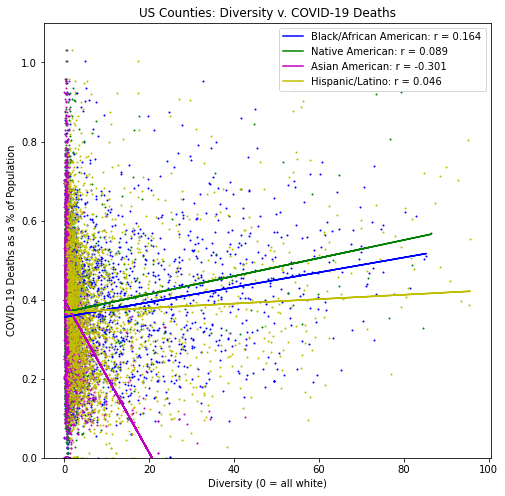

In [26]:
#diversity v. daeths scatter plot
x1 = df1['Black-Index']
y1 = df1['% Deaths']
plt.scatter(x1,y1,s = 1, c='b')

x2 = df1['Native-Index']
y2 = df1['% Deaths']
plt.scatter(x2,y2,s = 1, c='g')

x3 = df1['Asian-Index']
y3 = df1['% Deaths']
plt.scatter(x3,y3,s = 1, c='m')

x4 = df1['Latin-Index']
y4 = df1['% Deaths']
plt.scatter(x4,y4,s = 1, c='y')

plt.title("US Counties: Diversity v. COVID-19 Deaths")
plt.ylabel("COVID-19 Deaths as a % of Population")
plt.xlabel("Diversity (0 = all white)")

slope1, intercept1, r1, p1, std_err1 = st.linregress(x1,y1)
plt.plot(x1,slope1*x1+intercept1, color = 'b')

slope2, intercept2, r2, p2, std_er2r = st.linregress(x2,y2)
plt.plot(x2,slope2*x2+intercept2, color = 'g')

slope3, intercept3, r3, p3, std_er3r = st.linregress(x3,y3)
plt.plot(x3,slope3*x3+intercept3, color = 'm')

slope4, intercept4, r4, p4, std_err4 = st.linregress(x4,y4)
plt.plot(x4,slope4*x4+intercept4, color = 'y')

plt.legend([f"Black/African American: r = {round(r1,3)}",
            f"Native American: r = {round(r2,3)}",
            f"Asian American: r = {round(r3,3)}",
            f"Hispanic/Latino: r = {round(r4,3)}"])

plt.ylim(0,1.1)

plt.savefig('graphs/diversity_breakdown_v_deaths.png')

plt.show()


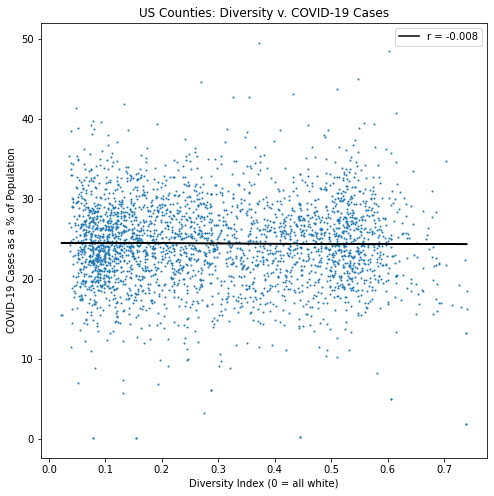

In [27]:
#diversity v.cases scatter plot
x = df1['Diversity-Index']
y = df1['% Cases']

plt.title("US Counties: Diversity v. COVID-19 Cases")
plt.ylabel("COVID-19 Cases as a % of Population")
plt.xlabel("Diversity Index (0 = all white)")
plt.scatter(x,y,s = 1)

slope, intercept, r, p, std_err = st.linregress(x,y)

plt.plot(x,slope*x+intercept, color = 'k')

plt.legend([f"r = {round(r,4)}"])

plt.savefig('graphs/diversity_v_cases.png')
plt.show()


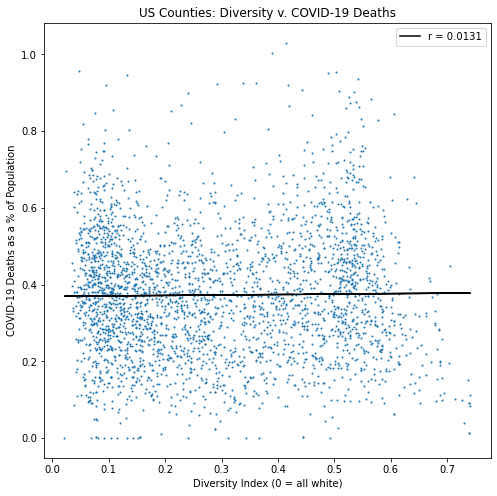

In [28]:
#diversity v. deaths scatter plot
x = df1['Diversity-Index']
y = df1['% Deaths']

plt.title("US Counties: Diversity v. COVID-19 Deaths")
plt.ylabel("COVID-19 Deaths as a % of Population")
plt.xlabel("Diversity Index (0 = all white)")
plt.scatter(x,y,s = 1)

slope, intercept, r, p, std_err = st.linregress(x,y)
plt.plot(x,slope*x+intercept, color = 'k')

plt.legend([f"r = {round(r,4)}"])
plt.savefig('graphs/diversity_v_deaths.png')
plt.show()

In [29]:
#1 line for mask mandate yes, 1 for mask mandate no
yes_mask_df = df2[df2['Face_Masks_Required_in_Public']=='Yes'].reset_index(drop = True)
no_mask_df = df2[df2['Face_Masks_Required_in_Public']=='No'].reset_index(drop = True)

#sum across weeks for cleaner looking data (account for variation in testing by day)
yes_mask_df['WeekDate'] = yes_mask_df.apply(lambda row: row['Date'] - dt.timedelta(days=row['Date'].weekday()), axis=1)
no_mask_df['WeekDate'] = no_mask_df.apply(lambda row: row['Date'] - dt.timedelta(days=row['Date'].weekday()), axis=1)
yes_mask_df = yes_mask_df.groupby('WeekDate').sum().reset_index()
no_mask_df = no_mask_df.groupby('WeekDate').sum().reset_index()

#no_mask data doesnt begin until 9/30/20, so limit yes_mask to the same date range
yes_mask_df = yes_mask_df[yes_mask_df['WeekDate'] >= min(no_mask_df['WeekDate'])]

#redo percentages
yes_mask_df['% Cases'] = yes_mask_df['Cases']/yes_mask_df['Population']*100
yes_mask_df['% Deaths'] = yes_mask_df['Deaths']/yes_mask_df['Population']*100
no_mask_df['% Cases'] = no_mask_df['Cases']/no_mask_df['Population']*100
no_mask_df['% Deaths'] = no_mask_df['Deaths']/no_mask_df['Population']*100

print(yes_mask_df.head())
print(no_mask_df.head())

     WeekDate   Cases  Deaths  Population   % Cases  % Deaths
25 2020-09-28  201894    3085  1683838545  0.011990  0.000183
26 2020-10-05  226071    2901  1708147980  0.013235  0.000170
27 2020-10-12  268652    3040  1740606495  0.015434  0.000175
28 2020-10-19  342842    3734  1756963417  0.019513  0.000213
29 2020-10-26  414996    3853  1760456404  0.023573  0.000219
    WeekDate  Cases  Deaths  Population   % Cases  % Deaths
0 2020-09-28   5066      77    45038388  0.011248  0.000171
1 2020-10-05   4444      88    20728953  0.021439  0.000425
2 2020-10-12   5074      70    20728953  0.024478  0.000338
3 2020-10-19   4121      76    17561553  0.023466  0.000433
4 2020-10-26   3443      60    14006178  0.024582  0.000428


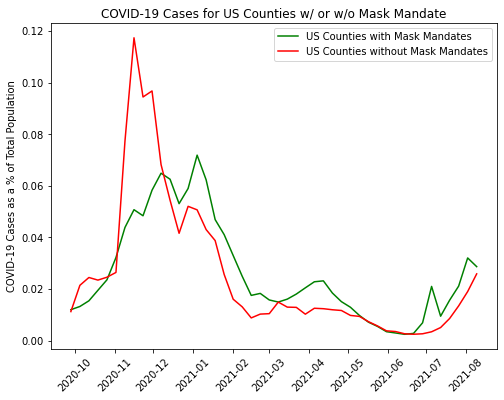

In [30]:
#set up graph
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(yes_mask_df['WeekDate'], yes_mask_df['% Cases'], 'g')
plt.plot(no_mask_df['WeekDate'], no_mask_df['% Cases'], 'r')
plt.title('COVID-19 Cases for US Counties w/ or w/o Mask Mandate')
plt.xticks(rotation = 45)
plt.ylabel('COVID-19 Cases as a % of Total Population')
plt.legend(["US Counties with Mask Mandates", "US Counties without Mask Mandates"])  
plt.savefig('graphs/cases_masks.png')
plt.show()

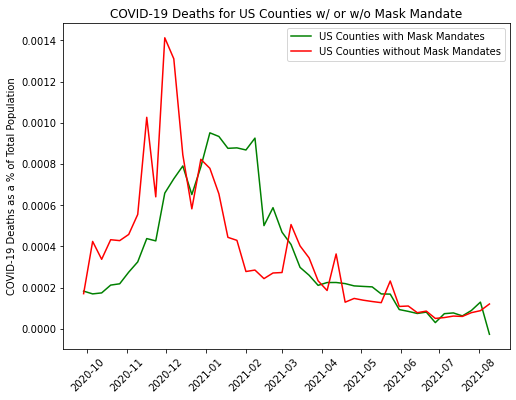

In [31]:
#set up graph
plt.plot(yes_mask_df['WeekDate'], yes_mask_df['% Deaths'], 'g')
plt.plot(no_mask_df['WeekDate'], no_mask_df['% Deaths'], 'r')
plt.title('COVID-19 Deaths for US Counties w/ or w/o Mask Mandate')
plt.xticks(rotation = 45)
plt.ylabel('COVID-19 Deaths as a % of Total Population')
plt.legend(["US Counties with Mask Mandates", "US Counties without Mask Mandates"])  
plt.savefig('graphs/deaths_masks.png')
plt.show()